# Multi-Scale Generalization on Morse Code with SITHCon 

For a more detailed look, check out the following paper published in PMLR: [A deep convolutional neural network that is invariant to time rescaling](https://proceedings.mlr.press/v162/jacques22a.html)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/compmem/sithshow/blob/main/examples/morse_code.ipynb)


In [1]:
!pip install -q SITHshow@git+https://github.com/compmem/SITHshow

In [2]:
from sithshow import model_utils, SITHCon_Classifier
from sithshow.dataset_utils import dataloader, pad_sequence

import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import equinox as eqx

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'}

def get_array_repr(code):
    return np.array([int(x) for x in code.replace('.', '10').replace('-', '1110')] + [0, 0])

X_arrs = [get_array_repr(code) for code in MORSE_CODE_DICT.values()]
Y = jnp.asarray(np.arange(len(MORSE_CODE_DICT)))

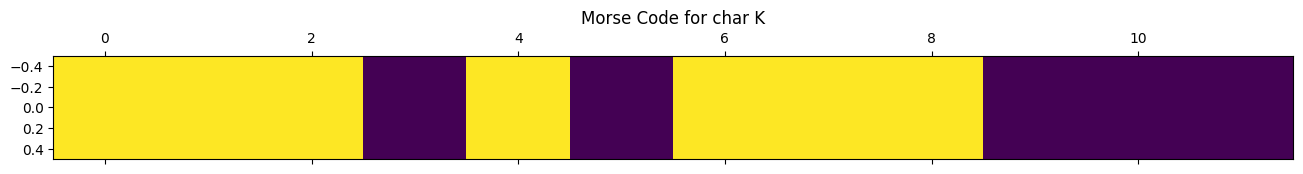

In [4]:
# Learning to identify a character by its morse code is a time-series classification problem.
# Let's take a look at the dataset:
letter_index = 10

plt.matshow(X_arrs[letter_index][None, ...])
plt.title(f"Morse Code for char {list(MORSE_CODE_DICT.keys())[letter_index]}"); 

In [5]:
# Hyperparameters:
BATCH_SIZE=10
LEARNING_RATE=3e-3
STEPS=2_000
SEED=5678

key = jrandom.PRNGKey(SEED)

# The longest sequence we're training on is length 22, so a tau_max of 50 will ensure 
# we're able to store all of the information in the sequence in the SITH working memory (and then some!)

sith_params = {'tau_min':.5,  # the center of the first temporal receptive field
               'tau_max': 50, # the center of the last temporal receptive field
               'n_taus': 50}  # the number of (log-spaced) temporal receptive fields

sithcon = SITHCon_Classifier(in_size=1, 
                             out_size=len(MORSE_CODE_DICT),
                             sith_params=sith_params,
                             key=key)

# The CME backend of SITH requires 64-bit precision, but none of the other parameters
# in the model do. Let's downcast them to 32-bit to speed up training.
sithcon = model_utils.cast_params_to_float32(sithcon)

In [6]:
# functions to optimize SITHCon params

optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(eqx.filter(sithcon, eqx.is_array))

@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_logits = jax.vmap(model)(x)

    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(pred_logits, y))

@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return loss, model, opt_state

def get_accuracy(X, Y):
    batch_model = jax.vmap(sithcon)

    pred = np.argmax(batch_model(X), 1)
    return np.sum(pred == Y) / len(MORSE_CODE_DICT)

In [7]:
# Let's train!

X = jnp.asarray(pad_sequence(X_arrs)[:, None, :])
iter_data = dataloader((X, Y), BATCH_SIZE)

losses = []

for step, (x, y) in tqdm(zip(range(STEPS), iter_data)):
    loss, sithcon, opt_state = make_step(sithcon, x, y, opt_state)
    losses.append(loss.item())

2000it [00:31, 62.78it/s]


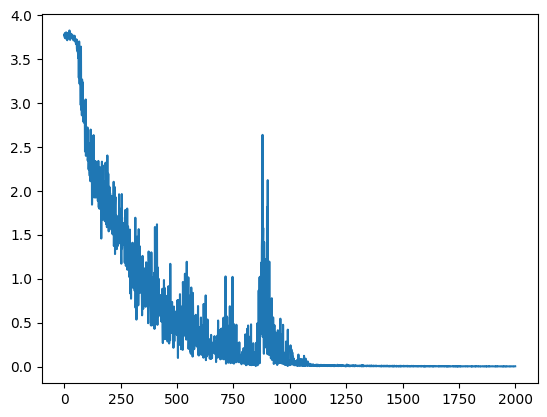

In [8]:
plt.plot(losses);

In [9]:
# The computational cost of running SITHCon increases with the number of temporal receptive fields (taus).
# To save compute, we can train on short sequences with a small working memory. Then, we can increase 
# the working memory of SITH post-hoc and rely on the scale-invariant property of SITHCon to generalize
# to longer timescales!

sithcon = model_utils.increase_n_taus_sithcon(sithcon, 250) # TODO: currently a hack in the backend

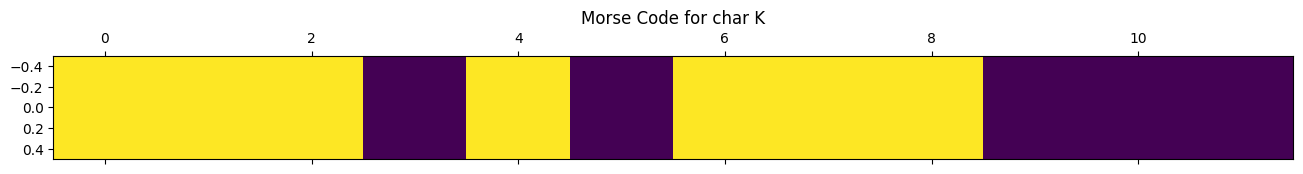

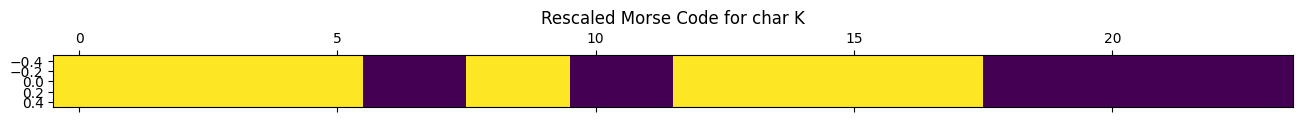

In [10]:
# Let's see how well we did by checking our accuracy on rescaled data. First, we'll see
# an example of the rescaled data.
def rescale(arr, factor=2):
    return np.repeat(arr, factor)

letter_index = 10

plt.matshow(X_arrs[letter_index][None, ...])
plt.title(f"Morse Code for char {list(MORSE_CODE_DICT.keys())[letter_index]}");

plt.matshow(rescale(X_arrs[letter_index], factor=2)[None, ...])
plt.title(f"Rescaled Morse Code for char {list(MORSE_CODE_DICT.keys())[letter_index]}");

In [11]:
# Now we'll evaluate!

accuracy = []
scale_factors = [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]

for i in scale_factors:
    rescaled_X_arrs = [rescale(arr, factor=i) for arr in X_arrs]
    rescaled_X = jnp.asarray(pad_sequence(rescaled_X_arrs)[:, None, :])

    accuracy.append(get_accuracy(rescaled_X, Y))

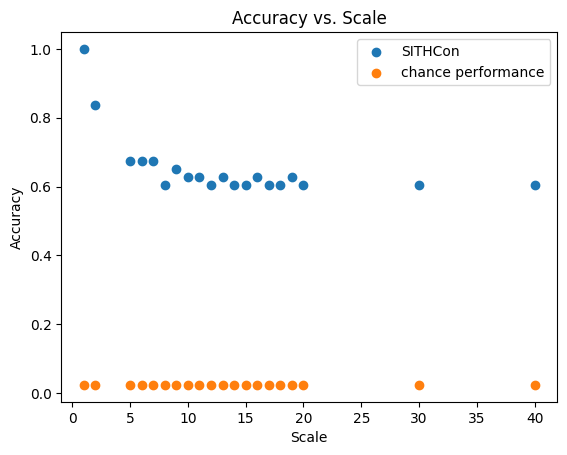

In [12]:
# Much better than chance! Can you tune the hyperparameters to improve performance?

plt.scatter(scale_factors, accuracy, label='SITHCon')
plt.scatter(scale_factors, np.ones(len(scale_factors))/(len(MORSE_CODE_DICT)), label='chance performance')
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Scale')
plt.legend();